# **Libraries**

In [51]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# **Data loading and exploration**

In [5]:
fpath = './Banana_Ripeness_Dataset_RemovedBG'
random_seed = 9

categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['totally_green', 'yellow_with_green_tips', 'yellow_with_brown_spots'] 

No. of categories =  3


In [7]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  1242 
No. of labels loaded =  1242
<class 'list'> <class 'list'>


In [8]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1242, 213, 320, 3) 
Labels shape =  (1242,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


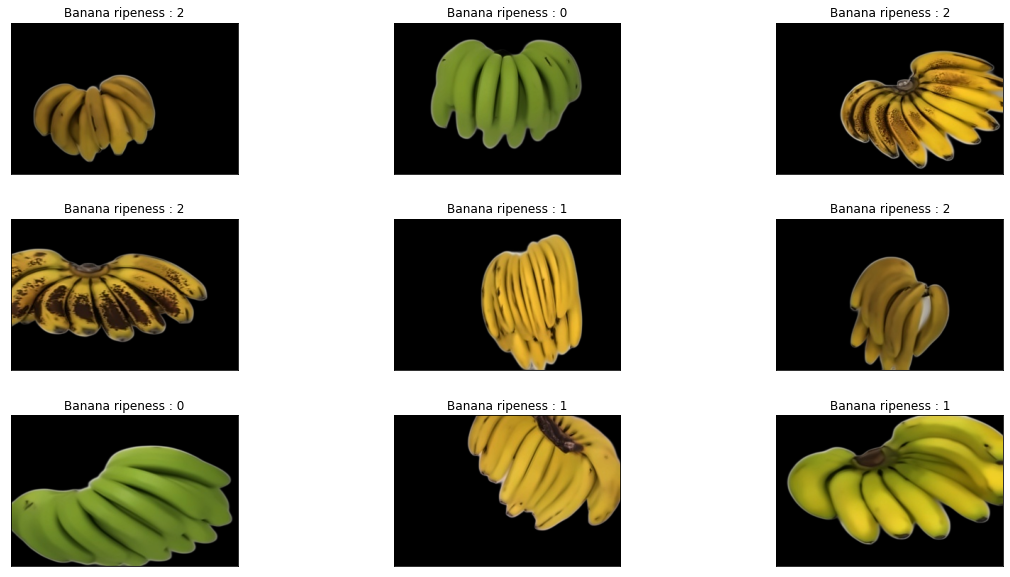

In [9]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Banana ripeness : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)


# **Prepare data for training the CNN model**

In [10]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1239 1240 1241]

'n' values after shuffling =  [661 924 660 ... 638 348 382]


In [11]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (1242, 213, 320, 3) 
Labels shape after shuffling =  (1242,)


In [12]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1242, 213, 320, 3)


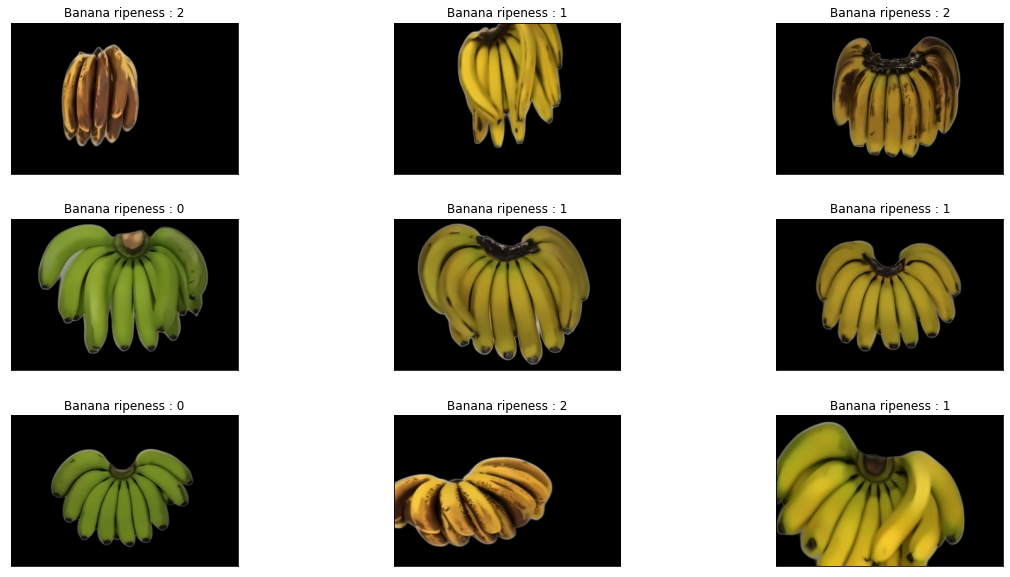

In [13]:
display_rand_images(images, labels)

In [34]:
train_ds, test_ds, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("train_ds shape = ",train_ds.shape)
print("train_labels shape = ",train_labels.shape)
print("\ntest_ds shape = ",test_ds.shape)
print("test_labels shape = ",test_labels.shape)

train_ds shape =  (993, 213, 320, 3)
train_labels shape =  (993,)

test_ds shape =  (249, 213, 320, 3)
test_labels shape =  (249,)


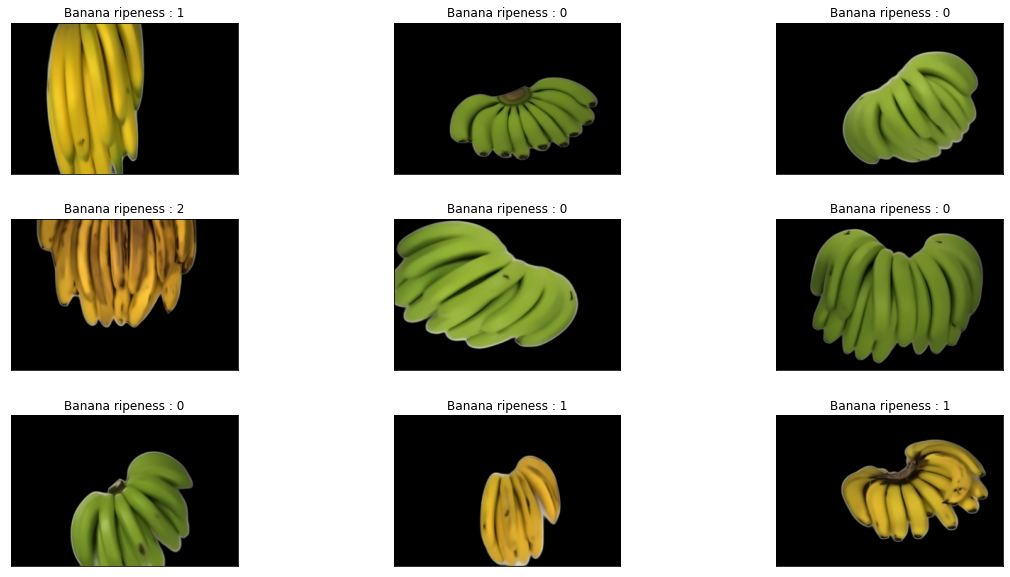

In [35]:
display_rand_images(train_ds, train_labels)

In [36]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

# **Define CNN model**

In [37]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [38]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [39]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

# **Train model**

In [42]:
%%time

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32)

Epoch 1/50
25/25 [==============================] - 43s 2s/step - loss: 1.1162 - accuracy: 0.3098 - val_loss: 1.0986 - val_accuracy: 0.3367
Epoch 2/50
25/25 [==============================] - 40s 2s/step - loss: 1.1014 - accuracy: 0.3463 - val_loss: 1.1046 - val_accuracy: 0.3668
Epoch 3/50
25/25 [==============================] - 41s 2s/step - loss: 1.0951 - accuracy: 0.4194 - val_loss: 1.0963 - val_accuracy: 0.3618
Epoch 4/50
25/25 [==============================] - 41s 2s/step - loss: 1.0938 - accuracy: 0.4181 - val_loss: 1.1091 - val_accuracy: 0.4422
Epoch 5/50
25/25 [==============================] - 41s 2s/step - loss: 1.0920 - accuracy: 0.4043 - val_loss: 1.1103 - val_accuracy: 0.2915
Epoch 6/50
25/25 [==============================] - 42s 2s/step - loss: 1.1031 - accuracy: 0.3375 - val_loss: 1.0869 - val_accuracy: 0.3618
Epoch 7/50
25/25 [==============================] - 42s 2s/step - loss: 1.0878 - accuracy: 0.3955 - val_loss: 1.1202 - val_accuracy: 0.5075
Epoch 8/50
25/25 [==

In [46]:
_, acc = model.evaluate(test_ds, test_labels, verbose=0)

print('> %.2f' % (acc * 100.0))

> 48.19


In [56]:
model_probs = model.predict(test_ds, verbose=0)
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(test_labels, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(test_labels, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

Accuracy: 48.19
F1 score: 37.07
Precision: 30.38
Recall: 48.19


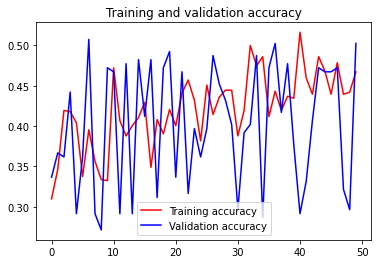

<Figure size 432x288 with 0 Axes>

In [43]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()